In [1]:
import sys
import os
# Add the parent directory to the Python path

# Change the current working directory to /app
os.chdir('/app')
from dotenv import load_dotenv
load_dotenv(dotenv_path='config/.env')
database_path = os.getenv('DATABASE_PATH')
from utils.db.fetch import fetch_entries
print(f'DATABASE_PATH: {database_path}')
market_name = 'indian_equity'
timeframe='1d'
import vectorbtpro as vbt

DATABASE_PATH: database/db/ohlcv_data.db


In [116]:
import os 
import sys
import pandas as pd
import scipy.optimize as sco
import numpy as np
from strategy.private.SOTM import get_signals
from finstore.finstore import Finstore
from utils.db.fetch import fetch_entries

finstore = Finstore(market_name='indian_equity', timeframe='1d')
symbol_list = finstore.read.get_symbol_list()
ohlcv_data = fetch_entries(market_name='indian_equity', timeframe='1d')

def annual_sharpe_ratio(weights, returns):
    # Calculate portfolio return
    portfolio_return = np.dot(weights, returns.mean()) * 252
    # Calculate portfolio standard deviation
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    # Return negative Sharpe ratio (since we minimize in optimization)
    return -portfolio_return / portfolio_volatility

def optimize_portfolio(returns):
    num_assets = returns.shape[1]
    # Initial guess for weights (equally weighted)
    initial_weights = np.ones(num_assets) / num_assets
    # Bounds for each weight
    bounds = tuple((0, 1) for _ in range(num_assets))
    # Constraint that weights must sum to 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    # Minimize the negative Sharpe ratio
    result = sco.minimize(
        annual_sharpe_ratio,
        initial_weights,
        args=(returns,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    return result.x if result.success else initial_weights

def calculate_optimized_weights(signal_function, params_list : list[dict]):

    portfolio_aggregrates = {}
    i = 0
    for params in params_list:
        
        entries, exits, close_data, open_data = signal_function(**params) 
        
        if 'top_n' in params:
            top_n = params['top_n']
        else:
            top_n = 10
        
        pf = vbt.Portfolio.from_signals(
            close=close_data,
            entries=entries,
            exits=exits,
            direction='longonly',
            init_cash = 100000,
            cash_sharing=True,
            size=1/top_n, 
            size_type="valuepercent",
            fees = 0.0005,
            slippage = 0.001,
            allow_partial=False,
            size_granularity=1.0,
            #sim_start=pd.Timestamp('2024-09-28'),
        )

        portfolio_aggregrates[i] = pf.get_daily_returns()
        i += 1
    
    df = pd.DataFrame(portfolio_aggregrates)
    df.dropna(inplace=True)

    years = df.index.year.unique()

    fitting_period = df[(df.index.year == years[-2])]
    #holdback_period = df[df.index.year == years[-1]]
    
    # Get optimal weights using the fitting period
    optimal_weights = optimize_portfolio(fitting_period)
    
    # Calculate the portfolio return for the holdback period
    #combined_return = (holdback_period * optimal_weights).sum(axis=1)

    combined_return = 0
    
    # Store the portfolio performance for the holdback period
    return combined_return, optimal_weights

    

def aggregated_entries_exits(ohlcv_data : dict, symbol_list : list, params : list):
    pass


params_list = [
    {'ohlcv_data': ohlcv_data, 'symbol_list': symbol_list, 'top_n': 10},
    {'ohlcv_data': ohlcv_data, 'symbol_list': symbol_list, 'top_n': 5, 'configuration' : 2},
    {'ohlcv_data': ohlcv_data, 'symbol_list': symbol_list, 'top_n': 5, 'configuration' : 2, 'slope_period' : 30},
    {'ohlcv_data': ohlcv_data, 'symbol_list': symbol_list, 'top_n': 5, 'configuration' : 2, 'slope_period' : 90},
    {'ohlcv_data': ohlcv_data, 'symbol_list': symbol_list, 'top_n': 10, 'configuration' : 2, 'slope_period' : 90},
]
combined_return, optimal_weights = calculate_optimized_weights(get_signals, params_list)

print(combined_return)
print(optimal_weights)

0
[5.16312786e-01 1.06631284e-16 3.54507838e-01 0.00000000e+00
 1.29179376e-01]


In [117]:
from executor.constructor import construct_portfolio
def aggregated_entries_exits(portfolio_value : int ,
                             sim_start : pd.Timestamp,
                             sim_end : pd.Timestamp,
                             optimal_weights : list,
                             params_list : list[dict], 
                             signal_function):
    
    assert len(params_list) == len(optimal_weights), "Length of params_list and optimal_weights must be the same"
    
    rounded_weights = [round(num, 1) for num in optimal_weights]
    portfolio_values = []
    
    for i in range(len(params_list)):
        adjusted_portfolio_value = portfolio_value * rounded_weights[i]
        pf = construct_portfolio(sim_start=sim_start, sim_end=sim_end, init_cash=adjusted_portfolio_value, params=params_list[i])
        portfolio_values.append(pf)
        
    return portfolio_values

In [118]:
pf_Values = aggregated_entries_exits(portfolio_value=1000000, sim_start=pd.Timestamp('2024-01-13'), sim_end=None, optimal_weights=optimal_weights, params_list=params_list, signal_function=get_signals)

empty
empty


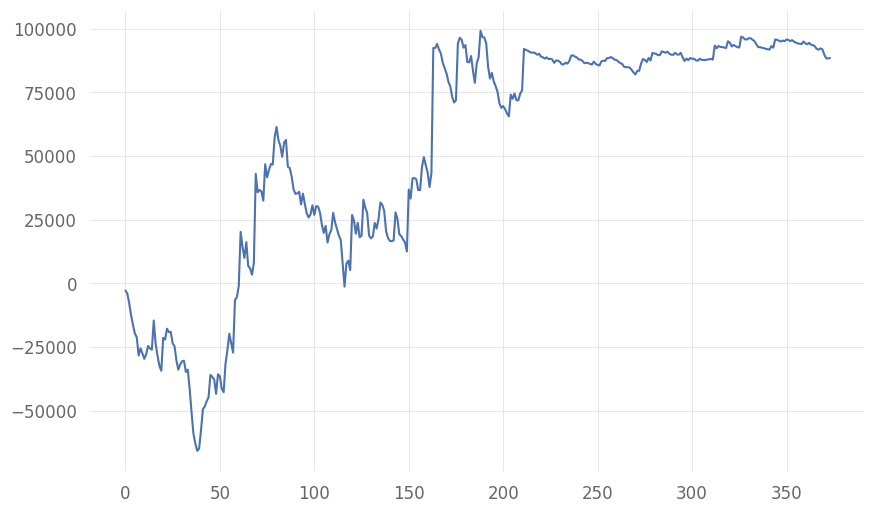

In [119]:
aggregated_pfs = pd.DataFrame()
for pf in pf_Values:
    if pf.trade_history.empty:
        print('empty')
    else:
        aggregated_pfs = pd.concat([aggregated_pfs, pf.trade_history[pf.trade_history['Side'] == 'Sell']], axis=0)
pnl = aggregated_pfs['PnL'].cumsum()
#pf_Values[0].trade_history
import matplotlib.pyplot as plt
import numpy as np

plt.plot(pnl.values)
plt.show()

In [108]:
aggregated_pfs[aggregated_pfs['Side'] == 'Sell']['PnL'].cumsum()

1       -4548.495560
3       -4055.110062
5       -2453.016989
7      -15110.562055
9       -4382.069720
           ...      
230    128514.519930
232    122359.120580
234    122231.104093
236    117247.135091
238    157232.310809
Name: PnL, Length: 117, dtype: float64

In [104]:
rounded_weights = [round(num, 1) for num in optimal_weights]
print(rounded_weights)


[0.0, 0.0, 1.0, 0.0, 0.0]
